# Import the dataset

In [11]:
!pip install kagglehub

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

Path to dataset files: /home/wandy/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1


# Visualize the dataset
Samples two random images per class

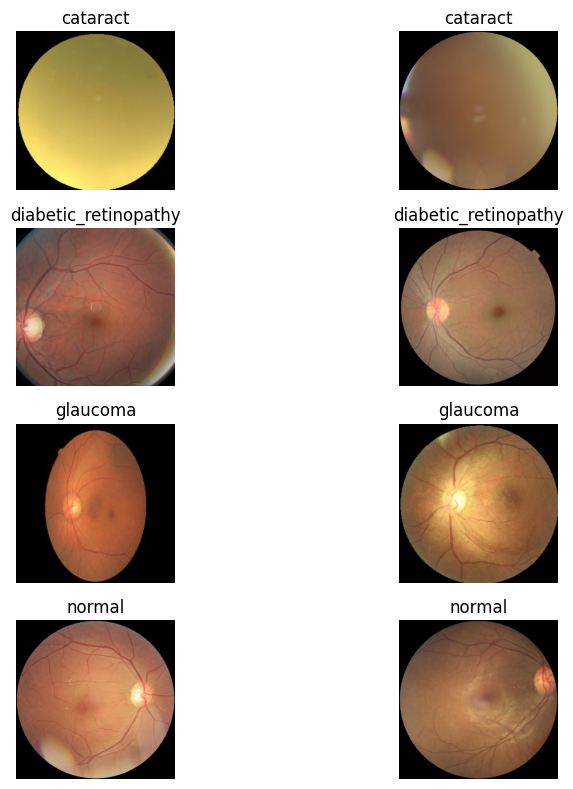

In [14]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Folder names (classes)
CLASSES = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# Dictionary to store sampled file paths
sampled_images = {}

# Randomly pick 2 images per class
for cls in CLASSES:
    folder_path = os.path.join(path,"dataset", cls)
    all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    sampled = random.sample(all_images, 2)
    sampled_images[cls] = [os.path.join(folder_path, img) for img in sampled]

# Display the sampled images
plt.figure(figsize=(10, 8))

idx = 1
for cls, img_paths in sampled_images.items():
    for img_path in img_paths:
        plt.subplot(4, 2, idx)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"{cls}")
        plt.axis("off")
        idx += 1

plt.tight_layout()
plt.show()


# Dataset Preprocessing

In [15]:
import os
import random
from pathlib import Path
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2   # if cv2 not available, install opencv-python


In [16]:
def load_image(path):
    img = Image.open(path)
    return img

def inspect_image(path):
    img = load_image(path)
    print("Path:", path)
    print("Mode:", img.mode)
    print("Size:", img.size)
    print("Dtype:", np.array(img).dtype)
    return img

# Example
# inspect_image("/path/to/some/image.jpg")


In [17]:
def resize_image_pil(img, target=(224,224), resample=Image.BILINEAR):
    return img.resize(target, resample=resample)


In [18]:
def resize_and_center_crop(img, target=(224,224)):
    w, h = img.size
    target_w, target_h = target
    scale = max(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    img_resized = img.resize((new_w, new_h), Image.LANCZOS)
    left = (new_w - target_w)//2
    top = (new_h - target_h)//2
    right = left + target_w
    bottom = top + target_h
    return img_resized.crop((left, top, right, bottom))


In [19]:
def ensure_rgb(img):
    if img.mode == "RGB":
        return img
    return img.convert("RGB")


In [20]:
def apply_clahe_mild(img_rgb, clip_limit=2.0, tile_grid_size=(8,8)):
    arr = np.array(img_rgb)
    r = arr[:, :, 0]
    g = arr[:, :, 1]
    b = arr[:, :, 2]

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    g_clahe = clahe.apply(g)

    merged = np.stack([r, g_clahe, b], axis=-1).astype(np.uint8)
    return Image.fromarray(merged)


In [21]:
def denoise_cv2(img_pil, h=10):
    arr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    denoised = cv2.fastNlMeansDenoisingColored(arr, None, h, h, 7, 21)
    denoised = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)
    return Image.fromarray(denoised)


In [22]:
def to_array_and_normalize(img_pil, scale_to_1=True):
    arr = np.array(img_pil).astype(np.float32)
    if scale_to_1:
        arr /= 255.0
    return arr  # shape (H, W, 3)


In [23]:
def preprocess_and_save_all(source_root, dest_root, classes, target=(224,224)):
    os.makedirs(dest_root, exist_ok=True)
    for cls in classes:
        src = Path(source_root) / cls
        dst_cls = Path(dest_root) / cls
        dst_cls.mkdir(parents=True, exist_ok=True)
        files = [f for f in src.iterdir() if f.suffix.lower() in (".jpg",".jpeg",".png")]
        for f in files:
            img = Image.open(str(f))
            img = ensure_rgb(img)
            img = resize_and_center_crop(img, target)
            img = apply_clahe_mild(img, clip_limit=1.5, tile_grid_size=(8,8))
            # optional denoise:
            # img = denoise_cv2(img, h=10)
            # normalization is done later by generator or saved as uint8
            save_path = dst_cls / f.name
            img.save(str(save_path), quality=95)
    print("Finished preprocessing and saved to", dest_root)

# Example usage:
# preprocess_and_save_all(SOURCE, "/home/wandy/improc/preprocessed_dataset", CLASSES, target=(224,224))


In [24]:
import matplotlib.pyplot as plt
def plot_random_samples(preprocessed_root, classes, n_per_class=4, target=(224,224)):
    plt.figure(figsize=(4 * n_per_class, 4 * len(classes)))
    idx = 1
    for i, cls in enumerate(classes):
        folder = Path(preprocessed_root) / cls
        files = [f for f in folder.iterdir() if f.suffix.lower() in (".jpg",".jpeg",".png")]
        sampled = random.sample(files, min(n_per_class, len(files)))
        for j, fpath in enumerate(sampled):
            img = Image.open(str(fpath))
            plt.subplot(len(classes), n_per_class, idx)
            plt.imshow(img)
            if j == 0:
                plt.ylabel(cls, fontsize=14)
            plt.title(fpath.name, fontsize=8)
            plt.axis("off")
            idx += 1
    plt.tight_layout()
    plt.show()

# Example:
# plot_random_samples("/home/wandy/improc/preprocessed_dataset", CLASSES, n_per_class=4)


In [25]:
# Minimal flow (run sequentially):
SOURCE = "/home/wandy/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1/dataset"
PREPROC = "/home/wandy/improc/UAS/preprocessed_dataset"
CLASSES = ["cataract","diabetic_retinopathy","glaucoma","normal"]
TARGET = (224,224)

preprocess_and_save_all(SOURCE, PREPROC, CLASSES, target=TARGET)
# After you visually verify, run your splitting code but point SOURCE to PREPROC


Finished preprocessing and saved to /home/wandy/improc/UAS/preprocessed_dataset


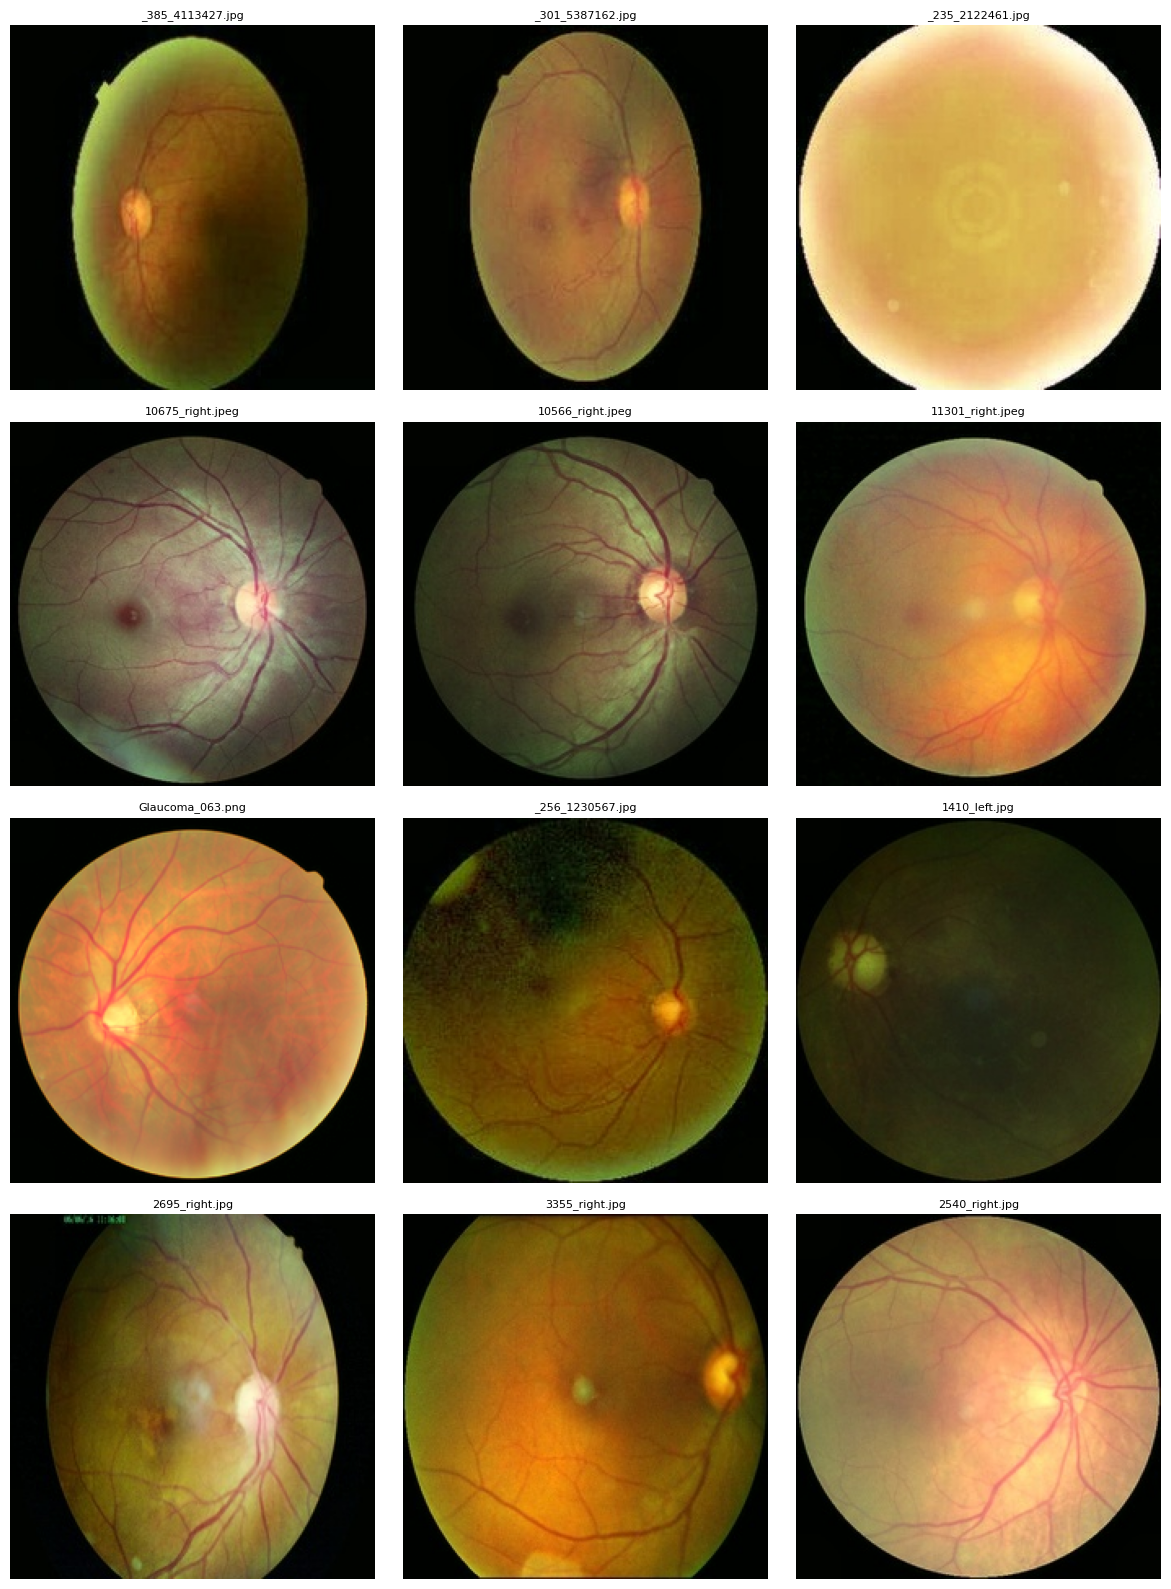

In [26]:
plot_random_samples(PREPROC, CLASSES, n_per_class=3)

# Splitting the Dataset
Data was split into train, test, and val with the composition 70% - 15% - 15%

In [27]:
import os
import shutil
import random

SOURCE = path + "/dataset"
DEST = "/home/wandy/improc/UAS/dataset_split"

CLASSES = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# --- NEW PART: remove previous destination folder ---
if os.path.exists(DEST):
    shutil.rmtree(DEST)    # deletes the whole folder and contents

# recreate fresh destination structure
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        os.makedirs(os.path.join(DEST, split, cls), exist_ok=True)

# --- dataset splitting ---
for cls in CLASSES:
    src_folder = os.path.join(SOURCE, cls)
    images = os.listdir(src_folder)
    random.shuffle(images)

    n = len(images)
    train_end = int(0.70 * n)
    val_end = int(0.85 * n)

    train_files = images[:train_end]
    val_files = images[train_end:val_end]
    test_files = images[val_end:]

    for f in train_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST, "train", cls))

    for f in val_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST, "val", cls))

    for f in test_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST, "test", cls))

print("Dataset successfully split and overwritten!")


Dataset successfully split and overwritten!


In [28]:
DEST = "/home/wandy/improc/UAS/dataset_split"

splits = ["train", "val", "test"]

print("\nSplit Dataset Counts:")
split_totals = {"train": 0, "val": 0, "test": 0}

for split in splits:
    print(f"\n[{split.upper()}]")
    for cls in CLASSES:
        folder = os.path.join(DEST, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
        split_totals[split] += count
        print(f"{cls}: {count}")

print("\nTOTALS:")
for split in splits:
    print(f"{split}: {split_totals[split]}")

print(f"\nGRAND TOTAL (train + val + test): {sum(split_totals.values())}")



Split Dataset Counts:

[TRAIN]
cataract: 726
diabetic_retinopathy: 768
glaucoma: 704
normal: 751

[VAL]
cataract: 156
diabetic_retinopathy: 165
glaucoma: 151
normal: 161

[TEST]
cataract: 156
diabetic_retinopathy: 165
glaucoma: 152
normal: 162

TOTALS:
train: 2949
val: 633
test: 635

GRAND TOTAL (train + val + test): 4217


# Import Libraries
Import all the libraries to ease development

In [29]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


2025-12-19 19:15:45.869547: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 19:15:46.405929: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-19 19:15:48.321534: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [30]:
import cv2

img = cv2.imread("/home/wandy/improc/UAS/dataset_split/train/diabetic_retinopathy/10035_right.jpeg")
height, width, _ = img.shape
print(f"Image Resolution: {width} x {height} pixels")

Image Resolution: 512 x 512 pixels


# Building the model
## Global Variables

In [35]:
DATASET_DIR = "/home/wandy/improc/UAS/dataset_split/"

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100


## Image augmentation

In [39]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


## Insert the image directory into the generator

In [40]:
train_generator = train_gen.flow_from_directory(
    DATASET_DIR + "train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)

val_generator = val_test_gen.flow_from_directory(
    DATASET_DIR + "val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)


Found 2949 images belonging to 4 classes.
Found 633 images belonging to 4 classes.


In [41]:
test_generator = val_test_gen.flow_from_directory(
    os.path.join(DATASET_DIR, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="sparse"
)


Found 635 images belonging to 4 classes.


## Transfer learning using ResNet50
The base of the ResNet50 is not trained at first, only taking the base convolutional layers. 
Global Average Pooling is used to reduce the last convolutional layer into a singular vector.
Dropout is to randomly turn of 40% of the neurons, creating a robust model
Dense using softmax (the FC layer)

In [21]:
base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base.trainable = False


I0000 00:00:1765180564.237946    2091 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [22]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = Model(inputs, outputs)


## Compile the current model

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Callbacks to tune the parameters mid-training

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]


## Unfreeze the base layers
To fine-tune the model, adapting the image features to the model

In [54]:
base.trainable = True

for layer in base.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [46]:
from sklearn.utils import class_weight
import numpy as np

# Extract labels from train generator
labels = train_generator.classes
cw = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
cw = dict(enumerate(cw))


# Grid Search

In [47]:
def build_model(unfreeze_mode="freeze_all", learning_rate=1e-4):
    base = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # === Unfreezing strategies ===
    if unfreeze_mode == "freeze_all":
        base.trainable = False

    elif unfreeze_mode == "unfreeze_20":
        base.trainable = True
        for layer in base.layers[:-20]:
            layer.trainable = False

    elif unfreeze_mode == "unfreeze_50":
        base.trainable = True
        for layer in base.layers[:-50]:
            layer.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(4, activation="softmax")(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [48]:
learning_rates = [1e-3, 1e-4, 1e-5]
early_stop_patience = [3, 5, 7]
lr_patience = [2, 3, 5]
unfreeze_modes = ["freeze_all", "unfreeze_20", "unfreeze_50"]

In [ ]:
import numpy as np

best_val_acc = 0.0
best_config = None
results = []

for lr in learning_rates:
    for es_pat in early_stop_patience:
        for lr_pat in lr_patience:
            for unfreeze in unfreeze_modes:

                print("\n==============================")
                print(f"LR={lr}, ES={es_pat}, LR_pat={lr_pat}, Unfreeze={unfreeze}")
                print("==============================")

                tf.keras.backend.clear_session()

                model = build_model(
                    unfreeze_mode=unfreeze,
                    learning_rate=lr
                )

                callbacks = [
                    EarlyStopping(
                        monitor="val_loss",
                        patience=es_pat,
                        restore_best_weights=True
                    ),
                    ReduceLROnPlateau(
                        monitor="val_loss",
                        patience=lr_pat,
                        factor=0.2,
                        min_lr=1e-6
                    )
                ]

                history = model.fit(
                    train_generator,
                    validation_data=val_generator,
                    epochs=100,
                    callbacks=callbacks,
                    class_weight=cw,
                    verbose=1
                )

                # ===== epoch information =====
                epochs_ran = len(history.history["loss"])
                best_epoch = np.argmax(history.history["val_accuracy"]) + 1
                max_val_acc = max(history.history["val_accuracy"])

                print(f"Epochs ran: {epochs_ran}")
                print(f"Best epoch: {best_epoch}")
                print(f"Best Val Acc: {max_val_acc:.4f}")

                results.append({
                    "learning_rate": lr,
                    "early_stop_patience": es_pat,
                    "lr_patience": lr_pat,
                    "unfreeze_mode": unfreeze,
                    "epochs_ran": epochs_ran,
                    "best_epoch": best_epoch,
                    "best_val_accuracy": max_val_acc
                })

                if max_val_acc > best_val_acc:
                    best_val_acc = max_val_acc
                    best_config = results[-1]



LR=0.001, ES=3, LR_pat=2, Unfreeze=freeze_all
Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.6629 - loss: 0.8559 - val_accuracy: 0.7646 - val_loss: 0.6049 - learning_rate: 0.0010
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 151ms/step - accuracy: 0.7728 - loss: 0.5816 - val_accuracy: 0.7773 - val_loss: 0.5437 - learning_rate: 0.0010
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.8026 - loss: 0.5170 - val_accuracy: 0.7915 - val_loss: 0.5244 - learning_rate: 0.0010
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 26s 141ms/step - accuracy: 0.8067 - loss: 0.5136 - val_accuracy: 0.7741 - val_loss: 0.6042 - learning_rate: 0.0010
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.8071 - loss: 0.4861 - val_accuracy: 0.8246 - val_loss: 0.4562 - learning_rate: 0.0010
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8162 - loss: 0.4837

In [ ]:
print("\n🏆 BEST CONFIGURATION FOUND:")
for k, v in best_config.items():
    print(f"{k}: {v}")

print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")


# Fitting the model

In [26]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    class_weight=cw
)


Epoch 1/20


2025-12-08 14:56:18.172761: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f728c003870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-08 14:56:18.172795: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-12-08 14:56:18.313771: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-08 14:56:19.483311: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


  1/185 ━━━━━━━━━━━━━━━━━━━━ 28:13 9s/step - accuracy: 0.1250 - loss: 2.3848

I0000 00:00:1765180583.464921   21386 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


185/185 ━━━━━━━━━━━━━━━━━━━━ 47s 207ms/step - accuracy: 0.4008 - loss: 1.4350 - val_accuracy: 0.6240 - val_loss: 0.9319 - learning_rate: 1.0000e-04
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - accuracy: 0.6056 - loss: 0.9558 - val_accuracy: 0.6746 - val_loss: 0.8049 - learning_rate: 1.0000e-04
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - accuracy: 0.6640 - loss: 0.8177 - val_accuracy: 0.6698 - val_loss: 0.7941 - learning_rate: 1.0000e-04
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 26s 140ms/step - accuracy: 0.6958 - loss: 0.7365 - val_accuracy: 0.6825 - val_loss: 0.7364 - learning_rate: 1.0000e-04
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.7223 - loss: 0.6791 - val_accuracy: 0.6967 - val_loss: 0.7096 - learning_rate: 1.0000e-04
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.7314 - loss: 0.6591 - val_accuracy: 0.6983 - val_loss: 0.7112 - learning_rate: 1.0000e-04
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - 

# Learning Curve of the model

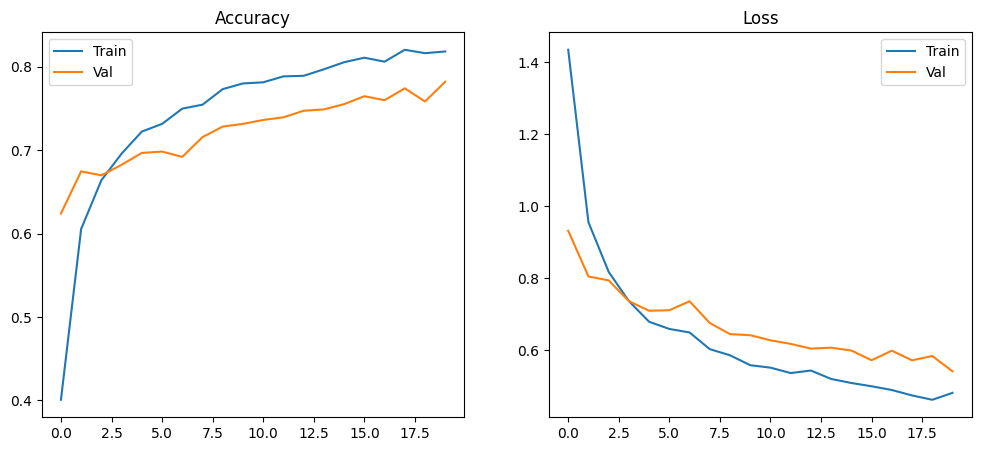

In [27]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Train", "Val"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(["Train", "Val"])

plt.show()


# Test Evaluation
## Accuracy

In [28]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.8409 - loss: 0.4188
Test Accuracy: 0.8409448862075806


## Inference on the test set

In [29]:
import numpy as np

# Get ground-truth labels
y_true = test_generator.classes

# Predict probabilities
y_pred_prob = model.predict(test_generator)

# Convert to predicted class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Class labels (in correct order)
class_names = list(test_generator.class_indices.keys())
print("Class order:", class_names)


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step
Class order: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


## Confusion matrix

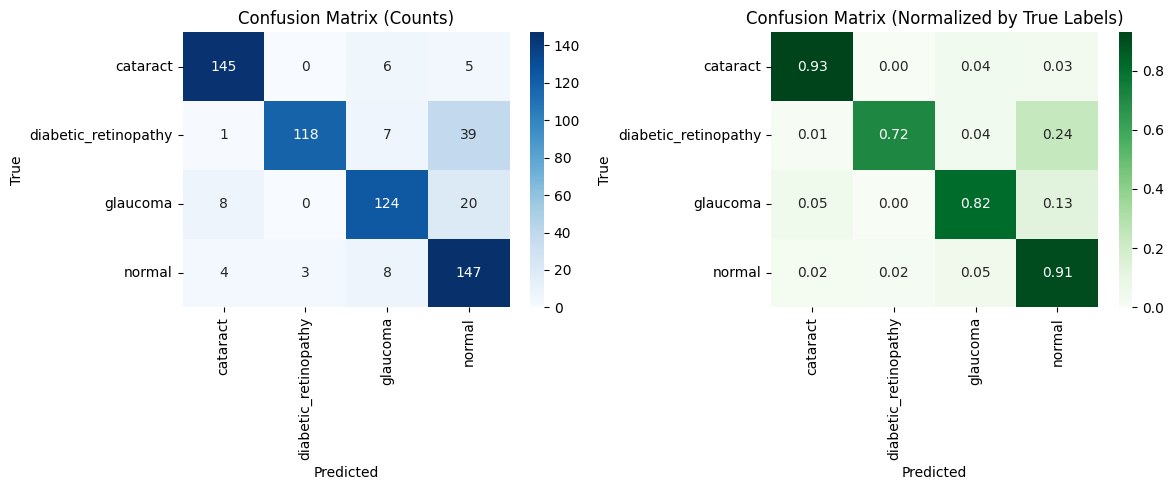

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(12,5))

# Raw confusion matrix
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")

# Normalized confusion matrix
plt.subplot(1,2,2)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Normalized by True Labels)")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()


## F1 Score

In [31]:
from sklearn.metrics import f1_score

f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("F1 Micro:     ", round(f1_micro, 4))
print("F1 Macro:     ", round(f1_macro, 4))
print("F1 Weighted:  ", round(f1_weighted, 4))


F1 Micro:      0.8409
F1 Macro:      0.843
F1 Weighted:   0.8423


## Summary of F1 Score

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))


                      precision    recall  f1-score   support

            cataract       0.92      0.93      0.92       156
diabetic_retinopathy       0.98      0.72      0.83       165
            glaucoma       0.86      0.82      0.84       152
              normal       0.70      0.91      0.79       162

            accuracy                           0.84       635
           macro avg       0.86      0.84      0.84       635
        weighted avg       0.86      0.84      0.84       635

